# Setup

In [1]:
!pip show fastai

Name: fastai
Version: 2.2.7
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: scikit-learn, packaging, pip, requests, fastprogress, spacy, fastcore, pillow, torch, matplotlib, scipy, torchvision, pandas, pyyaml
Required-by: 


In [2]:
!pip show biopython

Name: biopython
Version: 1.78
Summary: Freely available tools for computational molecular biology.
Home-page: https://biopython.org/
Author: The Biopython Contributors
Author-email: biopython@biopython.org
License: UNKNOWN
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy
Required-by: bio


In [3]:
from Bio import SeqIO
from fastai.text.all import *

# Data preparation

In [4]:
!wget -nc http://ftp.ensembl.org/pub/release-103/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.abinitio.fa.gz
!yes n | gunzip Homo_sapiens.GRCh38.cdna.abinitio.fa.gz

File ‘Homo_sapiens.GRCh38.cdna.abinitio.fa.gz’ already there; not retrieving.

gzip: Homo_sapiens.GRCh38.cdna.abinitio.fa already exists;	not overwritten
yes: standard output: Broken pipe


# Token preparation

Parse sequences from fasta file into list of sequences. Also put everything to lowercase in case there are mixed upper and lowercase. We don't want our model do learn that.

In [5]:
with open("Homo_sapiens.GRCh38.cdna.abinitio.fa", "rt") as handle:
  txts = L(str(record.seq).lower() for record in SeqIO.parse(handle, "fasta"))

We have 51 756 sequences, together 64 739 432 characters.

In [6]:
print(len(txts))
print(len(''.join(txts)))

51756
64739432


We will take first sequence for later testing and or even quicker work, lets use just 10 000 sequences for training.

In [7]:
txt = txts[0]
txts = txts[1:10001]

Now we have 10 000 sequences and 12 593 978 characters.

In [8]:
print(len(txts))
print(len(''.join(txts)))

10000
12593978


We will create subword tokenizer and make it create vocabulary of tokens based on our input data. Key parameter here is VOCAB_SIZE. In this example we are using VOCAB_SIZE = 70, what is 64 + 2 + 4, because we want 64 base tokens + 2 tokens respresenting special characters (unknow character and start of a sequence character) + 4 tokens for letters from alphabet. This size if 64 could in theory leads to codons, since we are working with coding DNA.



In [9]:
SPECIAL_TOKENS = 2
ALPHABET = 4
VOCAB_SIZE = 64 + SPECIAL_TOKENS + ALPHABET
tokenizer = SubwordTokenizer(vocab_sz=VOCAB_SIZE, special_toks=[], cache_dir='tmp/vocab64', lang='dna')
tokenizer.setup(txts)

{'sp_model': Path('tmp/vocab64/spm.model')}

Just to verify, that we have somehow reasonable tokes, split test sequence into tokens.

In [10]:
toks = first(tokenizer([txt]))
print(coll_repr(toks, 30))

(#396) ['▁','atg','gaa','ag','agga','aa','gaa','gaa','aaga','att','tcc','aa','taa','gtt','aca','aca','aa','ctt','t','tca','cca','ttc','taa','ag','aa','ccc','act','ttc','ctt','atc'...]


And print first 100 characters of our test sequence to compare it with tokens.

In [11]:
txt[:100]

'atggaaagaggaaagaagaaaagaatttccaataagttacaacaaacttttcaccattctaaagaacccactttccttatcaaccaagctgggcttctct'

Add Tokenizer on top of SubWordTokenizer. Not sure why this is needed, but I wasn't able to run it without this step.

I set rules=[] so no default rules will be applied - expecialy no encoding of repeating characters.

But maybe in future, some custom tokenizer with just special token for start of sequence would be nice. And for unkonown base - N.

In [12]:
tkn = Tokenizer(tokenizer, rules=[], sep='')
print(coll_repr(tkn(txt), 30))

(#396) ['▁','atg','gaa','ag','agga','aa','gaa','gaa','aaga','att','tcc','aa','taa','gtt','aca','aca','aa','ctt','t','tca','cca','ttc','taa','ag','aa','ccc','act','ttc','ctt','atc'...]


Now we will tokenize all 10 000 sequences using our predefined vocabulary.

In [13]:
toks_all = txts.map(tkn)

# Tokens analysis

Put tokens from all of our training sequences into one big list.

In [14]:
from operator import add

tokens = reduce(add, toks_all)append

Our sequences where splitted into 4 428 609 tokens.

In [15]:
len(tokens)

4428609

Print top 10 most common tokens.

In [16]:
import collections

elements_count = collections.Counter(tokens)
print(elements_count.most_common(10))

[('ag', 288473), ('aa', 200007), ('t', 195147), ('atg', 146084), ('gcc', 138483), ('gtg', 127102), ('aca', 116464), ('ccc', 114866), ('cca', 111307), ('tca', 107653)]


When we combine 3 most frequent tokens, we get 2 stop codons: TAG, TAA (DNA equivalents to RNA stop codons UAG, UAA). Fourth most frequent token is start codon ATG.
We had only 10 000 sequences, but number of occurences of ATG is 146 084, meaning, that it occured in every sequence on average 14 times.

What would be occurence count, if each codon would occure with the same probability?  
We have 12 593 978 bases in 10 000 sequences, so 1 259 bases on average in each sequence.

In [17]:
12593978 / 10000

1259.3978

That means that we have on average 419 codons per sequence.

In [18]:
1259/3

419.6666666666667

And each codon should occure on average 6.5 times in each sequence.

In [19]:
419/64

6.546875

# K-mer analysis

So far, we were working with tokens, not k-mers or codons. Splitting to tokens don't have to follow reading frame. Let'c count real codons now.

In [20]:
kmers = []
n = 3
for line in txts:
    for i in range(0, len(line), n):
        kmers.append(line[i:i+n])

Just to verify this simple splitting algorithm, we will compare numer of kmers with length of all sequences combined divided by 3. It should be roughtly the same.

In [21]:
len(kmers)

4198166

In [22]:
12593978/3

4197992.666666667

And now we can look at counts of k-mers.

In [23]:
kmer_count = collections.Counter(kmers)
print(kmer_count.most_common(64))

[('gag', 162692), ('ctg', 152165), ('cag', 145085), ('aag', 125114), ('gaa', 124566), ('gcc', 115964), ('gtg', 109645), ('aaa', 97552), ('ggc', 96296), ('gac', 95774), ('ccc', 91170), ('atg', 90696), ('agc', 84738), ('gga', 84329), ('gat', 82691), ('gct', 82438), ('cct', 81335), ('acc', 81106), ('ctc', 80716), ('cca', 80394), ('ggg', 80040), ('atc', 79047), ('tcc', 77118), ('gca', 76364), ('ttc', 72229), ('aac', 69332), ('aca', 68714), ('cac', 68226), ('aat', 67716), ('tct', 65649), ('agg', 63645), ('tgg', 63080), ('ttt', 61324), ('aga', 60767), ('gtc', 59355), ('tca', 58930), ('att', 56859), ('act', 56609), ('ctt', 55658), ('caa', 54859), ('tgc', 53201), ('agt', 52180), ('ggt', 51674), ('ttg', 51504), ('tac', 49967), ('cat', 49780), ('cgg', 47473), ('tgt', 45702), ('gtt', 44397), ('cgc', 42905), ('tat', 40561), ('ccg', 34331), ('gcg', 34257), ('cta', 29293), ('gta', 28494), ('tta', 28493), ('ata', 28452), ('cga', 25687), ('acg', 25266), ('cgt', 20176), ('tcg', 19701), ('tga', 7572), (

Now, ATG has 90 696 occurences, what is still more occurences then just start codon. But ATG is also encoding for amino acid Methoynin.  
Three least frequent codons are three stop codons: TGA, TAA and TAG. It is expected for them to occure only at the end of each sequence and not in the middle, because that would cause premature termination of traslation.

# Comparing subwords and k-mers

In [24]:
def get_all_possible_kmers(k, bases):
  return [''.join(p) for p in itertools.product(bases, repeat=k)]

bases = ['g', 'c', 'a', 't']
codons = get_all_possible_kmers(3, bases)

In [25]:
kmer_codons_counts = []
subword_codons_counts = []

for codon in codons:
    if codon in kmer_count:
        kmer_codons_counts.append(kmer_count[codon])
    else:
        kmer_codons_counts.append(0)
    if codon in elements_count:
        subword_codons_counts.append(elements_count[codon])
    else:
        subword_codons_counts.append(0)

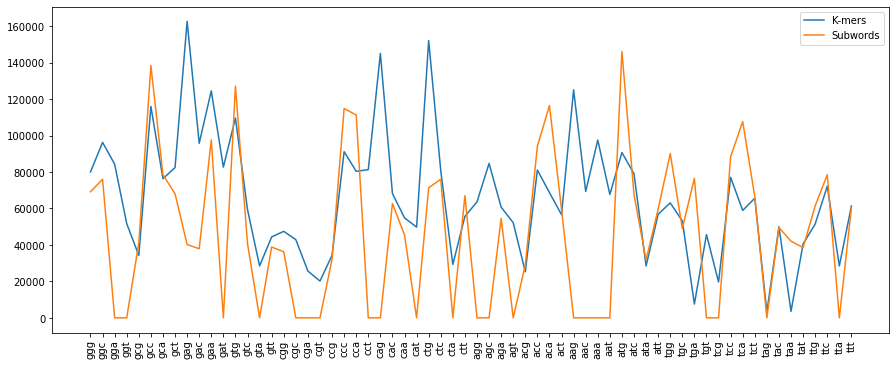

In [33]:
from matplotlib import pyplot

pyplot.figure(figsize=(15,6))
pyplot.plot(codons, kmer_codons_counts, label="K-mers")
pyplot.plot(codons, subword_codons_counts, label="Subwords")
plt.xticks(rotation=90)
pyplot.legend(loc='upper right')
pyplot.show()